In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from cods.od.data import MSCOCODataset
from cods.od.models import YOLOModel, DETRModel
import logging
import os
from cods.od.utils import (
    match_predictions_to_true_boxes,
    generalized_iou,
    assymetric_hausdorff_distance_old,
)
import numpy as np
from cods.od.loss import (
    ODBinaryClassificationLoss,
    ClassificationLossWrapper,
    PixelWiseRecallLoss,
)
import torch
import matplotlib.pyplot as plt


os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"  # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = (
    "0"  # chose the GPU. If only one, then "0"
)

logging.getLogger().setLevel(logging.INFO)

In [4]:
# set [COCO_PATH] to the directory to your local copy of the COCO dataset
COCO_PATH = "/datasets/shared_datasets/coco/"

data = MSCOCODataset(root=COCO_PATH, split="val")

calibration_ratio = (
    0.5  # set 0.5 to use 50% for calibration and 50% for testing
)

use_smaller_subset = True  # TODO: Temp

if use_smaller_subset:
    data_cal, data_val = data.split_dataset(
        calibration_ratio, shuffle=False, n_calib_test=800
    )
else:
    data_cal, data_val = data.split_dataset(calibration_ratio, shuffle=False)

print(f"{len(data) = }")
print(f"{len(data_cal) = }")
print(f"{len(data_val) = }")

len(data) = 5000
len(data_cal) = 400
len(data_val) = 400


In [5]:
def build_preds(model):
    preds_cal = model.build_predictions(
        data_cal,
        dataset_name="mscoco",
        split_name="cal",
        batch_size=12,
        collate_fn=data._collate_fn,  # TODO: make this a default for COCO
        shuffle=False,
        force_recompute=False,  # False,
        deletion_method="nms",
    )
    preds_val = model.build_predictions(
        data_val,
        dataset_name="mscoco",
        split_name="test",
        batch_size=12,
        collate_fn=data._collate_fn,
        shuffle=False,
        force_recompute=False,  # False,
        deletion_method="nms",
    )
    return preds_cal, preds_val

In [6]:
# Filter the preds_cal and preds_val with confidence below 0.001

def filter_preds(preds, confidence_threshold=0.001):
    filters = [
        conf > confidence_threshold
        if (conf > confidence_threshold).any()
        else conf.argmin(0)[None]
        for conf in preds.confidences
    ]
    preds.pred_boxes = [pbs[f] for pbs, f in zip(preds.pred_boxes, filters)]
    preds.pred_cls = [pcs[f] for pcs, f in zip(preds.pred_cls, filters)]
    preds.confidences = [
        conf[f] for conf, f in zip(preds.confidences, filters)
    ]
    return preds



In [7]:
model_detr50 = DETRModel(model_name="detr_resnet50", pretrained=True, device="cuda")
model_detr101 = DETRModel(model_name="detr_resnet101", pretrained=True, device="cuda")
model_yolov8x = YOLOModel(model_name="yolov8x.pt", pretrained=True, device="cuda")
models = [model_detr50, model_detr101, model_yolov8x]

Using cache found in /home/leo.andeol/.cache/torch/hub/facebookresearch_detr_main
/home/leo.andeol/envs/cods_13/cods/.venv/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/leo.andeol/envs/cods_13/cods/.venv/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Using cache found in /home/leo.andeol/.cache/torch/hub/facebookresearch_detr_main
/home/leo.andeol/envs/cods_13/cods/.venv/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum o

In [8]:
from  cods.od.cp import ODConformalizer

In [ ]:
import torch.nn.functional as F
def compute_set_sizes(preds_cal, preds_val, conf_thr=0.5, matching_function="lac", calibration=True, temperature=1.0):
    
    if calibration:
        
        old_pred_cls_cal = preds_cal.pred_cls
        old_pred_cls_val = preds_val.pred_cls
        
        preds_cal.pred_cls = list([p.detach().clone() for p in preds_cal.pred_cls])
        preds_val.pred_cls = list([p.detach().clone() for p in preds_val.pred_cls])
        
        preds_cal.pred_cls = list([F.softmax(p/temperature, dim=-1)for p in preds_cal.pred_cls])
        preds_val.pred_cls = list([F.softmax(p/temperature, dim=-1)for p in preds_val.pred_cls])
    

    conf = ODConformalizer(
        multiple_testing_correction=None,
        #confidence_method="box_count_recall",  # "box_thresholded_distance",  # "nb_boxes",
        confidence_threshold=conf_thr,
        localization_method="pixelwise",
        localization_prediction_set="additive",
        classification_method="binary",
        classification_prediction_set="lac",
        backend="auto",
        optimizer="binary_search",
        matching_function=matching_function,
        device="cuda",
    )


    parameters = conf.calibrate(
        preds_cal,
        #alpha_confidence=0.03,
        alpha_localization=0.03,
        alpha_classification=0.07,
        verbose=False, 
    )

    conformal_preds = conf.conformalize(preds_val, parameters=parameters, verbose=False)

    results_val = conf.evaluate(
        preds_val,
        parameters=parameters,
        conformalized_predictions=conformal_preds,
        include_confidence_in_global=False,
        verbose=True
    ) 
    
    if calibration:
        preds_cal.pred_cls = old_pred_cls_cal
        preds_val.pred_cls = old_pred_cls_val

    results = {}

    key_loc = f"{matching_function}-{conf_thr}-{calibration}-{temperature}-loc"
    key_cls = f"{matching_function}-{conf_thr}-{calibration}-{temperature}-cls"
                
    cls_ss = results_val.classification_set_sizes
    loc_ss = results_val.localization_set_sizes
    #cnf_ss = results_val.confidence_set_sizes
    results[key_cls] = (torch.mean(cls_ss.float()).item())
    results[key_loc] = (torch.mean(loc_ss.float()).item())

    return results

In [10]:
res = {}
for model in models:
    preds_cal, preds_val = build_preds(model)  
    preds_cal = filter_preds(preds_cal)
    preds_val = filter_preds(preds_val)
    
    key = f"{model.model_name}-nocal"
    res[key] = compute_set_sizes(preds_cal, preds_val, conf_thr=0.5, matching_function="mix", calibration=False, temperature=1.0)
    
    key = f"{model.model_name}-cal-1e-3"
    res[key] = compute_set_sizes(preds_cal, preds_val, conf_thr=0.5, matching_function="mix", calibration=True, temperature=1e-3)
    
    key = f"{model.model_name}-cal-1e-5"
    res[key] = compute_set_sizes(preds_cal, preds_val, conf_thr=0.5, matching_function="mix", calibration=True, temperature=1e-5)
    
    break

[2025-02-18 13:56:35:INFO:models.py:models:76 - _load_preds_if_exists ] Loading predictions from ./saved_predictions/2c92d1aaa0cc2db665dc992cc2c004015b949d723cda785c3c3a140ebe8a808b.pkl


[2025-02-18 13:56:35:INFO:models.py:models:76 - _load_preds_if_exists ] Loading predictions from ./saved_predictions/27b7022a01eb9f119e53d0e6c2c7e9a25a4444c25cea01599ce79e2a14f06cd0.pkl


Predictions already exist, loading them...
Predictions already exist, loading them...


[2025-02-18 13:56:35:WARNING:cp.py:cp:1409 - __init__ ] No multiple_testing_correction provided, assuming no correction is needed. The explicit list of alphas is expected for calibration.
[2025-02-18 13:56:35:INFO:cp.py:cp:188 - __init__ ] Defaulting to CRC backend
[2025-02-18 13:56:35:INFO:cp.py:cp:1013 - __init__ ] Defaulting to CRC backend
[2025-02-18 13:56:35:INFO:cp.py:cp:457 - calibrate ] Using overload confidence threshold: 0.5000
[2025-02-18 13:59:00:INFO:cp.py:cp:1146 - calibrate ] Using overload confidence threshold: 0.5000
[2025-02-18 13:59:00:WARNING:cp.py:cp:1151 - calibrate ] Currently considering that there is only one matching prediction to each true box for classification pruposes. To add later how to aggregate if multiple preidctions matched.
[2025-02-18 14:05:51:INFO:cp.py:cp:1763 - conformalize ] The parameters have been computed on another set of predictions.
[2025-02-18 14:05:51:INFO:cp.py:cp:1863 - evaluate ] Evaluating Localization Conformalizer


Confidence threshold is 0.5
Matching is : True
Confidence threshold is 0.5
Confidence threshold is 0.5


[2025-02-18 14:05:52:INFO:cp.py:cp:1876 - evaluate ] Evaluating Classification Conformalizer
100%|██████████| 400/400 [00:00<00:00, 447.62it/s]
[2025-02-18 14:05:53:INFO:cp.py:cp:1906 - evaluate ] Evaluation Results:
[2025-02-18 14:05:53:INFO:cp.py:cp:1914 - evaluate ] 	 Localization:
[2025-02-18 14:05:53:INFO:cp.py:cp:1915 - evaluate ] 		 Risk: nan
[2025-02-18 14:05:53:INFO:cp.py:cp:1916 - evaluate ] 		 Mean Set Size: 6.88
[2025-02-18 14:05:53:INFO:cp.py:cp:1920 - evaluate ] 	 Classification:
[2025-02-18 14:05:53:INFO:cp.py:cp:1921 - evaluate ] 		 Risk: 0.06
[2025-02-18 14:05:53:INFO:cp.py:cp:1922 - evaluate ] 		 Mean Set Size: 10.95
[2025-02-18 14:05:53:INFO:cp.py:cp:1926 - evaluate ] 	 Global:
[2025-02-18 14:05:53:INFO:cp.py:cp:1927 - evaluate ] 		 Risk: nan


KeyError: 'mix-0.5-False-1.0-cls'

In [12]:
res = {}
for model in models:
    preds_cal, preds_val = build_preds(model)  
    preds_cal = filter_preds(preds_cal)
    preds_val = filter_preds(preds_val)
    
    #key = f"{model.model_name}-nocal"
    #res[key] = compute_set_sizes(preds_cal, preds_val, conf_thr=0.5, matching_function="mix", calibration=False, temperature=1.0)
    
    key = f"{model.model_name}-cal-1e-3"
    res[key] = compute_set_sizes(preds_cal, preds_val, conf_thr=0.5, matching_function="mix", calibration=True, temperature=1e-3)
    
    key = f"{model.model_name}-cal-1e-5"
    res[key] = compute_set_sizes(preds_cal, preds_val, conf_thr=0.5, matching_function="mix", calibration=True, temperature=1e-5)
    
    break

[2025-02-18 14:06:35:INFO:models.py:models:76 - _load_preds_if_exists ] Loading predictions from ./saved_predictions/2c92d1aaa0cc2db665dc992cc2c004015b949d723cda785c3c3a140ebe8a808b.pkl
[2025-02-18 14:06:35:INFO:models.py:models:76 - _load_preds_if_exists ] Loading predictions from ./saved_predictions/27b7022a01eb9f119e53d0e6c2c7e9a25a4444c25cea01599ce79e2a14f06cd0.pkl


Predictions already exist, loading them...
Predictions already exist, loading them...


[2025-02-18 14:06:35:WARNING:cp.py:cp:1409 - __init__ ] No multiple_testing_correction provided, assuming no correction is needed. The explicit list of alphas is expected for calibration.
[2025-02-18 14:06:35:INFO:cp.py:cp:188 - __init__ ] Defaulting to CRC backend
[2025-02-18 14:06:35:INFO:cp.py:cp:1013 - __init__ ] Defaulting to CRC backend
[2025-02-18 14:06:35:INFO:cp.py:cp:457 - calibrate ] Using overload confidence threshold: 0.5000
[2025-02-18 14:09:00:INFO:cp.py:cp:1146 - calibrate ] Using overload confidence threshold: 0.5000
[2025-02-18 14:09:00:WARNING:cp.py:cp:1151 - calibrate ] Currently considering that there is only one matching prediction to each true box for classification pruposes. To add later how to aggregate if multiple preidctions matched.


ValueError: No good lambda found

In [ ]:
temps = np.logspace(-1, 2, 10)
res = {}
preds_cal, preds_val = build_preds(model)
preds_cal = filter_preds(preds_cal)
preds_val = filter_preds(preds_val)
model = model_detr50
for temp in temps:
    key = f"{model.model_name}-cal-{temp}"
    

In [13]:
res = {}
for model in models:
    preds_cal, preds_val = build_preds(model)  
    preds_cal = filter_preds(preds_cal)
    preds_val = filter_preds(preds_val)
    
    #key = f"{model.model_name}-nocal"
    #res[key] = compute_set_sizes(preds_cal, preds_val, conf_thr=0.5, matching_function="mix", calibration=False, temperature=1.0)
    
    key = f"{model.model_name}-cal-1e3"
    res[key] = compute_set_sizes(preds_cal, preds_val, conf_thr=0.5, matching_function="mix", calibration=True, temperature=1e3)
    
    key = f"{model.model_name}-cal-1e5"
    res[key] = compute_set_sizes(preds_cal, preds_val, conf_thr=0.5, matching_function="mix", calibration=True, temperature=1e5)
    
    break

[2025-02-18 14:16:28:INFO:models.py:models:76 - _load_preds_if_exists ] Loading predictions from ./saved_predictions/2c92d1aaa0cc2db665dc992cc2c004015b949d723cda785c3c3a140ebe8a808b.pkl
[2025-02-18 14:16:29:INFO:models.py:models:76 - _load_preds_if_exists ] Loading predictions from ./saved_predictions/27b7022a01eb9f119e53d0e6c2c7e9a25a4444c25cea01599ce79e2a14f06cd0.pkl


Predictions already exist, loading them...
Predictions already exist, loading them...


[2025-02-18 14:16:29:WARNING:cp.py:cp:1409 - __init__ ] No multiple_testing_correction provided, assuming no correction is needed. The explicit list of alphas is expected for calibration.
[2025-02-18 14:16:29:INFO:cp.py:cp:188 - __init__ ] Defaulting to CRC backend
[2025-02-18 14:16:29:INFO:cp.py:cp:1013 - __init__ ] Defaulting to CRC backend
[2025-02-18 14:16:29:INFO:cp.py:cp:457 - calibrate ] Using overload confidence threshold: 0.5000
[2025-02-18 14:18:57:INFO:cp.py:cp:1146 - calibrate ] Using overload confidence threshold: 0.5000
[2025-02-18 14:18:57:WARNING:cp.py:cp:1151 - calibrate ] Currently considering that there is only one matching prediction to each true box for classification pruposes. To add later how to aggregate if multiple preidctions matched.
[2025-02-18 14:26:49:INFO:cp.py:cp:1763 - conformalize ] The parameters have been computed on another set of predictions.
[2025-02-18 14:26:50:INFO:cp.py:cp:1863 - evaluate ] Evaluating Localization Conformalizer


Confidence threshold is 0.5
Matching is : True
Confidence threshold is 0.5
Confidence threshold is 0.5


[2025-02-18 14:26:50:INFO:cp.py:cp:1876 - evaluate ] Evaluating Classification Conformalizer
100%|██████████| 400/400 [00:00<00:00, 439.74it/s]
[2025-02-18 14:26:52:INFO:cp.py:cp:1906 - evaluate ] Evaluation Results:
[2025-02-18 14:26:52:INFO:cp.py:cp:1914 - evaluate ] 	 Localization:
[2025-02-18 14:26:52:INFO:cp.py:cp:1915 - evaluate ] 		 Risk: nan
[2025-02-18 14:26:52:INFO:cp.py:cp:1916 - evaluate ] 		 Mean Set Size: 2.49
[2025-02-18 14:26:52:INFO:cp.py:cp:1920 - evaluate ] 	 Classification:
[2025-02-18 14:26:52:INFO:cp.py:cp:1921 - evaluate ] 		 Risk: 0.07
[2025-02-18 14:26:52:INFO:cp.py:cp:1922 - evaluate ] 		 Mean Set Size: 79.30
[2025-02-18 14:26:52:INFO:cp.py:cp:1926 - evaluate ] 	 Global:
[2025-02-18 14:26:52:INFO:cp.py:cp:1927 - evaluate ] 		 Risk: nan


KeyError: 'mix-0.5-True-1000.0-cls'

In [14]:
res = {}
for model in models:
    preds_cal, preds_val = build_preds(model)  
    preds_cal = filter_preds(preds_cal)
    preds_val = filter_preds(preds_val)
    
    #key = f"{model.model_name}-nocal"
    #res[key] = compute_set_sizes(preds_cal, preds_val, conf_thr=0.5, matching_function="mix", calibration=False, temperature=1.0)
    
    key = f"{model.model_name}-cal-1e-3"
    res[key] = compute_set_sizes(preds_cal, preds_val, conf_thr=0.5, matching_function="mix", calibration=True, temperature=1e-3)
    
    break

[2025-02-18 14:30:57:INFO:models.py:models:76 - _load_preds_if_exists ] Loading predictions from ./saved_predictions/2c92d1aaa0cc2db665dc992cc2c004015b949d723cda785c3c3a140ebe8a808b.pkl
[2025-02-18 14:30:57:INFO:models.py:models:76 - _load_preds_if_exists ] Loading predictions from ./saved_predictions/27b7022a01eb9f119e53d0e6c2c7e9a25a4444c25cea01599ce79e2a14f06cd0.pkl


Predictions already exist, loading them...
Predictions already exist, loading them...


[2025-02-18 14:30:58:WARNING:cp.py:cp:1409 - __init__ ] No multiple_testing_correction provided, assuming no correction is needed. The explicit list of alphas is expected for calibration.
[2025-02-18 14:30:58:INFO:cp.py:cp:188 - __init__ ] Defaulting to CRC backend
[2025-02-18 14:30:58:INFO:cp.py:cp:1013 - __init__ ] Defaulting to CRC backend
[2025-02-18 14:30:58:INFO:cp.py:cp:457 - calibrate ] Using overload confidence threshold: 0.5000
[2025-02-18 14:33:24:INFO:cp.py:cp:1146 - calibrate ] Using overload confidence threshold: 0.5000
[2025-02-18 14:33:24:WARNING:cp.py:cp:1151 - calibrate ] Currently considering that there is only one matching prediction to each true box for classification pruposes. To add later how to aggregate if multiple preidctions matched.


ValueError: No good lambda found

In [ ]:
import torch
confidence = torch.concatenate(preds_val.confidences)
preds_boxes = torch.concatenate(preds_val.pred_boxes)

set_sizes = torch.sqrt((preds_boxes[:, 2] - preds_boxes[:, 0]) * (preds_boxes[:, 3] - preds_boxes[:, 1]))

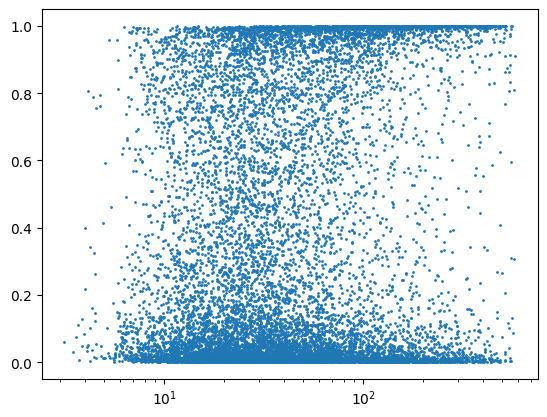

In [ ]:
import matplotlib.pyplot as plt

conf =  confidence.cpu().numpy()
ss = set_sizes.cpu().numpy()

plt.scatter(ss, conf, s=1)
plt.xscale("log")

(array([   0.005343,    0.011457,    0.011457,    0.012724,    0.011512,   0.0096946,   0.0080972,    0.006665,   0.0060591,   0.0055634,   0.0055083,   0.0051227,   0.0044066,   0.0041312,   0.0045168,   0.0037456,   0.0035253,   0.0038007,    0.003305,   0.0031948,   0.0030296,   0.0020381,   0.0017076,   0.0015974,
          0.0021482,   0.0014322,   0.0012118,    0.001322,   0.0011567,   0.0011567,  0.00099149,  0.00088133,  0.00088133,   0.0012669,  0.00093641,  0.00099149,  0.00071608,   0.0012118,   0.0011017,  0.00082624,  0.00049575,  0.00088133,  0.00077116,  0.00049575,  0.00071608,  0.00066099,  0.00038558,  0.00027541,
          0.0003305,  0.00060591,  0.00060591,  0.00049574,  0.00071608,  0.00038558,  0.00038558,  0.00027542,   0.0003305,  0.00038558,  0.00022033,  0.00049575,  0.00027541,  0.00016525,   0.0003305,  0.00016525,   0.0003305,   0.0003305,   0.0003305,  0.00027542,  0.00027541,   0.0003305,  0.00027542,  0.00027541,
         0.00022033,  0.00022033,  0.000

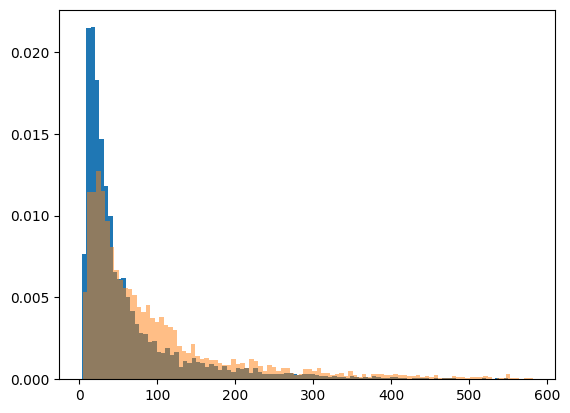

In [ ]:
plt.hist(ss[conf<0.2], bins=100, density=True, alpha=1)
#plt.hist(ss[np.logical_and(conf>=0.2, conf<=0.8)], bins=100, density=True, alpha=0.5)
plt.hist(ss[conf>0.8], bins=100, density=True, alpha=0.5)